In [ ]:
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Layer, Input, LSTM, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from scipy.special import rel_entr


In [26]:
# Global variables
BATCH_SIZE = 128
EPOCHS = 100

In [27]:
# Get the class weights from a JSON file
with open('class_weights.json', "r") as f:
    class_weight_dict = json.load(f)

In [28]:
# Preprocessed data
X_train = np.load('preprocessed_data/X_train.npy')
y_train = np.load('preprocessed_data/y_train.npy')
X_test = np.load('preprocessed_data/X_test.npy')
y_test = np.load('preprocessed_data/y_test.npy')

In [29]:
# Transform the y_train and y_test labels to categorical
y_train_cat = to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_cat = to_categorical(y_test, num_classes=len(np.unique(y_train)))

In [30]:
# Vlastná Attention vrstva (kompatibilná s LSTM výstupom)
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)  
        a = K.softmax(e, axis=1)              
        output = x * a                         
        return K.sum(output, axis=1)           

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [31]:
# Model definition
inputs = Input(shape=(60, X_train.shape[2]))
x = LSTM(64, return_sequences=True)(inputs)
x = Dropout(0.3)(x)
x = LSTM(32, return_sequences=True)(x)
x = Dropout(0.3)(x)
attention = AttentionLayer()(x)  # Tu sa aplikuje attention
dense1 = Dense(64, activation='relu')(attention)
drop1 = Dropout(0.3)(dense1)
outputs = Dense(len(np.unique(y_train)), activation='softmax')(drop1)

model = Model(inputs=inputs, outputs=outputs)

In [32]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [34]:
# Train the model
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)

Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.4868 - loss: 1.3478 - val_accuracy: 0.6272 - val_loss: 0.9277
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.6471 - loss: 0.9137 - val_accuracy: 0.6808 - val_loss: 0.7983
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.6678 - loss: 0.8342 - val_accuracy: 0.6971 - val_loss: 0.7430
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.6920 - loss: 0.7662 - val_accuracy: 0.7138 - val_loss: 0.6989
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7023 - loss: 0.7370 - val_accuracy: 0.7338 - val_loss: 0.6847
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.7139 - loss: 0.7174 - val_accuracy: 0.7256 - val_loss: 0.6884
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7233 - loss: 0.6976 - val_accuracy: 0.7130 - val_loss: 0.7244
Epoch 8/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7235 - loss: 0.6978 -

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


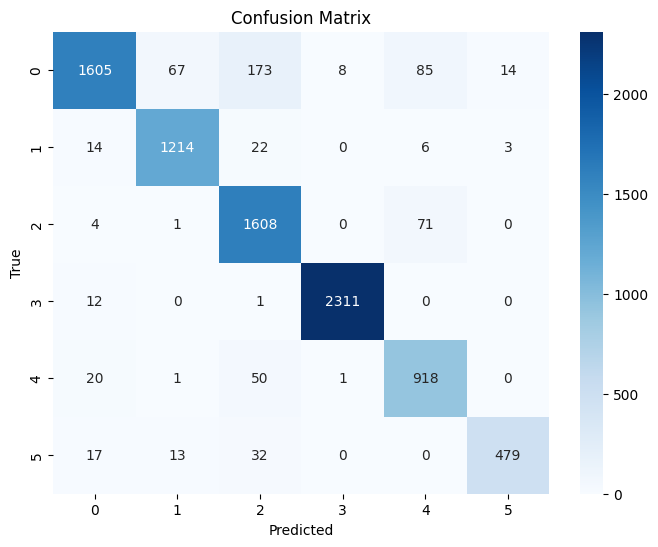

In [39]:
# Predictions
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [40]:
# Classification report
print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.960     0.822     0.886      1952
           1      0.937     0.964     0.950      1259
           2      0.853     0.955     0.901      1684
           3      0.996     0.994     0.995      2324
           4      0.850     0.927     0.887       990
           5      0.966     0.885     0.924       541

    accuracy                          0.930      8750
   macro avg      0.927     0.925     0.924      8750
weighted avg      0.933     0.930     0.930      8750



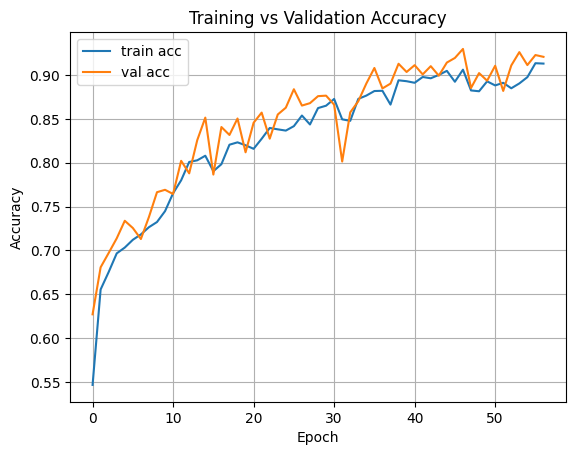

In [41]:
# Plot the training history
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [42]:
# Save the model
model.save('trained_models/lstm_attention_model.h5')
model.save('trained_models/lstm_attention_model.keras')